Necessary imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

%matplotlib inline


MinMaxReg()

Regularisation function for images. 

Used formula:
val = (val-min)/(max-min)


In [2]:
def minmaxreg(img):
    """min-max regularization

    Args:
        img (ndarray): input image

    Returns:
        ndarray: regularized image
    """
    max = img.max()
    min = img.min()
    img[:,:] = (img[:,:]-min)/(max-min)*255        
    return img

Dataread()

To read csv files and return training data as np-array and respective labels.

(4831, 4096)
(4831,)
(1611, 4096)
(1611,)


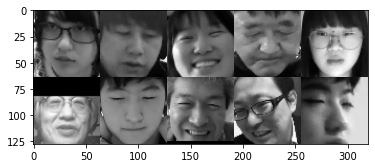

In [3]:
def dataread(filename, viewsample = False, showprogress = False, imgreshapesize = (64,64)):
    """read csv data as images and labels

    Args:
        filename (str): path to csv file
        viewsample (bool, optional): to view 5 sample images from dataset. Defaults to False.
        showprogress (bool, optional): to show loading progress. Defaults to False.
        imgreshapesize (tuple, optional): reshape all images to this shape. Defaults to (40,40).

    Returns:
        tuple: (ndarray) image data in flattened order, (ndarray) labels for the images, (ndarray or None), sample images if {viewsample}
    """
    data = pd.read_csv(filename)
    data = data.to_numpy(np.str_)
    data[data[:,1] == 'positive smile', 1] = 2
    data[data[:,1] == 'negative smile', 1] = 1
    data[data[:,1] == 'NOT smile', 1] = 0

    m = data.shape[0]

    img_data = np.zeros((m,imgreshapesize[0]**2))
    labels = np.zeros((m))

    for i in range(m):
        fname = data[i, 0]
        label = int(data[i, 1])
        img = cv2.imread("data/happy_images/"+fname+".jpg")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, imgreshapesize)
        img = minmaxreg(img)

        img_data[i] = img.ravel()
        labels[i] = label
        if(showprogress):
            if(i%100 == 0):
                print(f"done: {i}")
            
        # plt.imshow(img)
    
    labels = labels.ravel()

    if(viewsample):
        emptyimg = np.zeros((imgreshapesize[0],1))
        for i in range(5):
            randindex = np.random.randint(0, m)
            emptyimg = np.hstack((emptyimg, np.reshape(img_data[randindex],imgreshapesize)))
        emptyimg = emptyimg[:,1:]
        plt.imshow(emptyimg, cmap='gray')
        return img_data, labels, emptyimg

    return img_data, labels, None


imgReshapeSize = (64,64)
train_data ,train_label, train_sample = dataread("data/train.csv", viewsample=True, showprogress=False, imgreshapesize=imgReshapeSize)
test_data, test_label, test_sample = dataread("data/test.csv", viewsample=True, showprogress=False, imgreshapesize=imgReshapeSize)

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

if(train_sample.any() != None and test_sample.any() != None):
    sample = np.vstack((train_sample, test_sample))
    plt.imshow(sample, cmap='gray')
    

Defining and Training the model

Used a sequential model with 1 hidden layers {rectified linear activation}

In [4]:
n = imgReshapeSize[0]
# tf.random.set_seed(0)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (n**2,1)),
    tf.keras.layers.Dense(n**2, activation='relu'),
    tf.keras.layers.Dense(3)
])

model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.fit(train_data, train_label, epochs=16)

loss, accuracy = model.evaluate(test_data, test_label, verbose=2)

print(f"Testing Accuracy: {round(accuracy*100, 2)}%")

Epoch 1/16
151/151 [==============================] - 2s 5ms/step - loss: 459.3656 - accuracy: 0.5790
Epoch 2/16
151/151 [==============================] - 1s 5ms/step - loss: 100.9474 - accuracy: 0.6017
Epoch 3/16
151/151 [==============================] - 1s 6ms/step - loss: 30.4298 - accuracy: 0.6260
Epoch 4/16
151/151 [==============================] - 1s 5ms/step - loss: 14.4541 - accuracy: 0.6417
Epoch 5/16
151/151 [==============================] - 1s 5ms/step - loss: 10.7009 - accuracy: 0.6518
Epoch 6/16
151/151 [==============================] - 1s 5ms/step - loss: 4.5360 - accuracy: 0.6551
Epoch 7/16
151/151 [==============================] - 1s 5ms/step - loss: 2.5643 - accuracy: 0.6576
Epoch 8/16
151/151 [==============================] - 1s 5ms/step - loss: 1.7007 - accuracy: 0.6839
Epoch 9/16
151/151 [==============================] - 1s 5ms/step - loss: 1.4384 - accuracy: 0.6897
Epoch 10/16
151/151 [==============================] - 1s 5ms/step - loss: 0.7481 - accuracy:

Model save and Load utilities

In [7]:
def saveModel(model, filename='trained_model'):
    """save a trained model as {filename}

    Args:
        model (tf.keras.Model): model to be saved
        filename (str): name to save as
    """
    model.save(filename)

def loadModel(filename='trained_model'):
    """trained model is loaded

    Args:
        filename: name of trained model

    Returns:
        tf.keras.Model: trained model is loaded
    """
    model = tf.keras.models.load_model('trained_model')
    return model

saveModel(model)

model = loadModel()

INFO:tensorflow:Assets written to: trained_model\assets
